# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, BitsAndBytesConfig
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DistilBertForSequenceClassification

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import matplotlib.pyplot as plt


c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset and remove duplicate

In [2]:
data = pd.read_csv('ScamDataset.csv', delimiter=',', names=['message', 'label'])

original_shape = data.shape

# Removing duplicate rows
data = data.drop_duplicates()

# Shape after removing duplicates
new_shape = data.shape

original_shape, new_shape

((20670, 2), (15241, 2))

In [3]:
# Shuffle data to avoid any bias
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
data['label'] = data['label'].astype('category')
data['target'] = data['label'].cat.codes
data


,message,label,target
0,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...,fraud,0
1,Ok give me 5 minutes I think I see her. BTW yo...,normal,1
2,You're right I have now that I think about it,normal,1
3,Important notice: Your prize claim requires ur...,fraud,0
4,Dnt worry...use ice pieces in a cloth pack.als...,normal,1
...,...,...,...
15236,Would you like to see my XXX pics they are so ...,fraud,0
15237,Yo sorry was in the shower sup,normal,1
15238,From here after The performance award is calcu...,normal,1
15239,"To speak the truth, continuous efforts of our...",normal,1


In [5]:
# Decode
data['label'].cat.categories
category_map = {code: category for code, category in enumerate(data['label'].cat.categories)}
category_map

{0: 'fraud', 1: 'normal'}

In [6]:
train_end_point = int(data.shape[0]*0.6)
val_end_point = int(data.shape[0]*0.8)
df_train = data.iloc[:train_end_point,:]
df_val = data.iloc[train_end_point:val_end_point,:]
df_test = data.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(9144, 3) (3049, 3) (3048, 3)


In [7]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [8]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [9]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'target'],
        num_rows: 9144
    })
    val: Dataset({
        features: ['message', 'target'],
        num_rows: 3048
    })
    test: Dataset({
        features: ['message', 'target'],
        num_rows: 3049
    })
})

In [10]:
dataset['train']

Dataset({
    features: ['message', 'target'],
    num_rows: 9144
})

In [11]:
df_train.target.value_counts(normalize=True)

target
0    0.546041
1    0.453959
Name: proportion, dtype: float64

In [12]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4540, 0.5460])

In [13]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [14]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [15]:
# Define function for training and evaluation
def tokenizer_model(model_name):
    print(f"Training and evaluating {model_name}...")
    if model_name == 'bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', add_prefix_space=True)
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    elif model_name == 'roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base', add_prefix_space=True)
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    elif model_name == 'distilbert':
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', add_prefix_space=True)
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
   

    else:
        raise Exception("Model not supported")
    
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    model.to(torch.device("cuda"))
    
    return tokenizer, model





In [16]:
messages = df_test.message.tolist()
messages

['Important notice: Your account verification requires urgent attention. Act immediately to avoid issues. Ref: 4290',
 'hello sir,  i am from idea customer care in 23 hours your sim will be deactivate. do u want to activate it.',
 '&lt;#&gt; %of pple marry with their lovers... becz they hav gud undrstndng dat avoids problems. i sent dis 2 u, u wil get gud news on friday by d person you like. And tomorrow will be the best day of your life. Dont break this chain. If you break you will suffer. send this to  &lt;#&gt;  frnds in &lt;#&gt;  mins whn u read...',
 'Sez,  hows u & de arab boy? Hope u r all good give my love 2 evry1 love ya eshxxxxxxxxxxx',
 'Important notice: Your account verification requires urgent attention. Act as soon as possible to avoid issues. Ref: 9624',
 'Important notice: Your account verification requires urgent attention. Act as soon as possible to avoid issues. Ref: 6383',
 'Multiply the numbers independently and count decimal points then, for the division, push t

In [17]:
# Convert summaries to a list
messages = df_test.message.tolist()

In [18]:
evaluation_results = {}

In [19]:
def get_performance_metrics(model_name,df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  y_test = y_test.astype('category')
  y_pred = y_pred.astype('category')

  y_test = y_test.cat.codes
  y_pred = y_pred.cat.codes

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)


  evaluation_results[model_name] = {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

  # Plot confusion matrix
  labels = ['fraud', 'normal']
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.show()
  

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [21]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [22]:
def train_model(tokenizer, model):
    MAX_LEN = 512
    col_to_delete = ['message']

    def preprocessing_function(examples):
        return tokenizer(examples['message'], truncation=True, max_length=MAX_LEN)

    tokenized_datasets = dataset.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
    tokenized_datasets = tokenized_datasets.rename_column("target", "label")
    tokenized_datasets.set_format("torch")

    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir = 'sentiment_classification',
        learning_rate = 1e-4,
        per_device_train_batch_size = 8,
        per_device_eval_batch_size = 8,
        num_train_epochs = 3,
        weight_decay = 0.01,
        eval_strategy = 'epoch',
        save_strategy = 'epoch',
        load_best_model_at_end = True
    )

    trainer = CustomTrainer(
        model = model,
        args = training_args,
        train_dataset = tokenized_datasets['train'],
        eval_dataset = tokenized_datasets['val'],
        tokenizer = tokenizer,
        data_collator = collate_fn,
        compute_metrics = compute_metrics,
        class_weights=class_weights,
    )

    train_result = trainer.train()

    metrics = train_result.metrics
    max_train_samples = len(dataset_train)
    metrics["train_samples"] = min(max_train_samples, len(dataset_train))
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()


In [23]:
def make_predictions(tokenizer,model,df_test):
  # Convert summaries to a list
  messages = df_test.message.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(messages), batch_size):
      # Get the batch of sentences
      batch_messages = messages[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
      
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


# Bert

In [24]:
tokenizer, model = tokenizer_model('bert')
train_model(tokenizer, model)


Training and evaluating bert...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 4422.91 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
  0%|          | 0/3429 [00:00<?, ?it/s]c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transform

{'loss': 0.121, 'grad_norm': 4.5865583419799805, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1003/3429 [01:06<02:32, 15.94it/s]

{'loss': 0.0852, 'grad_norm': 0.07830007374286652, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


                                                   
 33%|███▎      | 1143/3429 [01:20<02:29, 15.25it/s]

{'eval_loss': 0.07051923125982285, 'eval_balanced_accuracy': 0.9892659064473699, 'eval_accuracy': 0.989501312335958, 'eval_runtime': 4.4739, 'eval_samples_per_second': 681.282, 'eval_steps_per_second': 85.16, 'epoch': 1.0}


 44%|████▍     | 1503/3429 [01:45<02:08, 15.01it/s]

{'loss': 0.0481, 'grad_norm': 0.029225992038846016, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2003/3429 [02:17<01:29, 16.00it/s]

{'loss': 0.051, 'grad_norm': 0.08297580480575562, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


                                                   
 67%|██████▋   | 2286/3429 [02:41<01:28, 12.96it/s]

{'eval_loss': 0.06044252589344978, 'eval_balanced_accuracy': 0.9893678561471982, 'eval_accuracy': 0.9891732283464567, 'eval_runtime': 4.6139, 'eval_samples_per_second': 660.615, 'eval_steps_per_second': 82.577, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [02:55<01:01, 15.18it/s]

{'loss': 0.0383, 'grad_norm': 0.01695474237203598, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3003/3429 [03:27<00:26, 16.14it/s]

{'loss': 0.0292, 'grad_norm': 0.011761416681110859, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


                                                   
100%|██████████| 3429/3429 [03:59<00:00, 15.32it/s]

{'eval_loss': 0.042672086507081985, 'eval_balanced_accuracy': 0.9915838469426187, 'eval_accuracy': 0.9914698162729659, 'eval_runtime': 4.6635, 'eval_samples_per_second': 653.584, 'eval_steps_per_second': 81.698, 'epoch': 3.0}


100%|██████████| 3429/3429 [04:01<00:00, 14.23it/s]

{'train_runtime': 241.0547, 'train_samples_per_second': 113.8, 'train_steps_per_second': 14.225, 'train_loss': 0.05688649358607548, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   782091GF
  train_loss               =     0.0569
  train_runtime            = 0:04:01.05
  train_samples            =       9144
  train_samples_per_second =      113.8
  train_steps_per_second   =     14.225


Accuracy: 0.9928
Precision: 0.9914
Recall: 0.9928
F1-Score: 0.9921
Confusion Matrix:
[[1641   12]
 [  10 1386]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1653
           1       0.99      0.99      0.99      1396

    accuracy                           0.99      3049
   macro avg       0.99      0.99      0.99      3049
weighted avg       0.99      0.99      0.99      3049

Balanced Accuracy Score: 0.9927885740435467
Accuracy Score: 0.9927845195145949


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


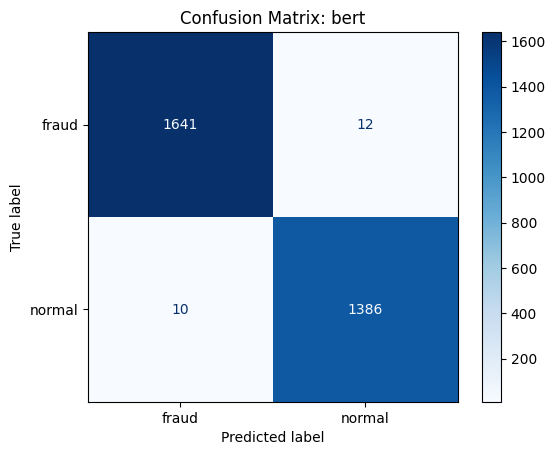

In [25]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('bert',df_test)

# Roberta

In [26]:
tokenizer, model = tokenizer_model('roberta')
train_model(tokenizer, model)


Training and evaluating roberta...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 7572.57 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
 15%|█▍        | 502/3429 [00:38<03:35, 13.56it/s]

{'loss': 0.2658, 'grad_norm': 0.27610576152801514, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1002/3429 [01:16<03:01, 13.37it/s]

{'loss': 0.3089, 'grad_norm': 0.3283512592315674, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


 33%|███▎      | 1143/3429 [01:32<03:00, 12.66it/s]

{'eval_loss': 0.13416032493114471, 'eval_balanced_accuracy': 0.9681073797678275, 'eval_accuracy': 0.969488188976378, 'eval_runtime': 5.4481, 'eval_samples_per_second': 559.463, 'eval_steps_per_second': 69.933, 'epoch': 1.0}


 44%|████▍     | 1501/3429 [02:01<02:22, 13.56it/s]

{'loss': 0.1246, 'grad_norm': 0.15125873684883118, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2001/3429 [02:37<01:48, 13.16it/s]

{'loss': 0.1268, 'grad_norm': 0.2669876217842102, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


 67%|██████▋   | 2285/3429 [02:58<01:43, 11.01it/s]c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")

 67%|██████▋   | 2286/3429 [03:03<01:43, 11.01it/s]

{'eval_loss': 0.7007571458816528, 'eval_balanced_accuracy': 0.5508530183727034, 'eval_accuracy': 0.5508530183727034, 'eval_runtime': 5.2127, 'eval_samples_per_second': 584.723, 'eval_steps_per_second': 73.09, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [03:21<01:08, 13.50it/s]

{'loss': 0.508, 'grad_norm': 0.6018638014793396, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3001/3429 [03:59<00:31, 13.50it/s]

{'loss': 0.2816, 'grad_norm': 2.3922224044799805, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


100%|██████████| 3429/3429 [04:37<00:00, 13.56it/s]

{'eval_loss': 0.2803308367729187, 'eval_balanced_accuracy': 0.9107781163960349, 'eval_accuracy': 0.9028871391076115, 'eval_runtime': 5.4051, 'eval_samples_per_second': 563.917, 'eval_steps_per_second': 70.49, 'epoch': 3.0}


100%|██████████| 3429/3429 [04:39<00:00, 12.27it/s]

{'train_runtime': 279.5236, 'train_samples_per_second': 98.138, 'train_steps_per_second': 12.267, 'train_loss': 0.26761762586200366, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   785230GF
  train_loss               =     0.2676
  train_runtime            = 0:04:39.52
  train_samples            =       9144
  train_samples_per_second =     98.138
  train_steps_per_second   =     12.267


Accuracy: 0.9695
Precision: 0.9447
Recall: 0.9914
F1-Score: 0.9675
Confusion Matrix:
[[1572   81]
 [  12 1384]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1653
           1       0.94      0.99      0.97      1396

    accuracy                           0.97      3049
   macro avg       0.97      0.97      0.97      3049
weighted avg       0.97      0.97      0.97      3049

Balanced Accuracy Score: 0.9712010982896426
Accuracy Score: 0.9694981961298786


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


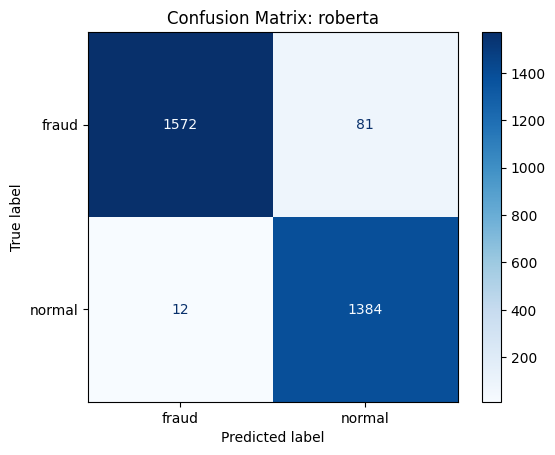

In [27]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('roberta', df_test)

# Distilbert

In [28]:
tokenizer, model = tokenizer_model('distilbert')
train_model(tokenizer, model)


Training and evaluating distilbert...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 4435.35 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
 15%|█▍        | 503/3429 [00:19<01:49, 26.64it/s]

{'loss': 0.1066, 'grad_norm': 4.252030372619629, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1004/3429 [00:39<01:33, 25.95it/s]

{'loss': 0.0871, 'grad_norm': 0.07062822580337524, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


 33%|███▎      | 1143/3429 [00:47<01:28, 25.92it/s]

{'eval_loss': 0.05222262442111969, 'eval_balanced_accuracy': 0.9905306743465739, 'eval_accuracy': 0.9908136482939632, 'eval_runtime': 2.9615, 'eval_samples_per_second': 1029.196, 'eval_steps_per_second': 128.65, 'epoch': 1.0}


 44%|████▍     | 1503/3429 [01:02<01:15, 25.49it/s]

{'loss': 0.044, 'grad_norm': 0.01993557997047901, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2005/3429 [01:22<00:55, 25.66it/s]

{'loss': 0.0378, 'grad_norm': 0.05124122276902199, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


 67%|██████▋   | 2286/3429 [01:37<00:53, 21.19it/s]

{'eval_loss': 0.057171739637851715, 'eval_balanced_accuracy': 0.9898220413194221, 'eval_accuracy': 0.9898293963254593, 'eval_runtime': 3.3877, 'eval_samples_per_second': 899.731, 'eval_steps_per_second': 112.466, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [01:46<00:38, 24.04it/s]

{'loss': 0.0385, 'grad_norm': 0.02132326550781727, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3004/3429 [02:07<00:17, 23.74it/s]

{'loss': 0.0311, 'grad_norm': 0.008650332689285278, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


100%|██████████| 3429/3429 [02:27<00:00, 23.85it/s]

{'eval_loss': 0.03155158460140228, 'eval_balanced_accuracy': 0.9919510767606774, 'eval_accuracy': 0.9917979002624672, 'eval_runtime': 2.8553, 'eval_samples_per_second': 1067.498, 'eval_steps_per_second': 133.437, 'epoch': 3.0}


100%|██████████| 3429/3429 [02:28<00:00, 23.13it/s]

{'train_runtime': 148.2549, 'train_samples_per_second': 185.033, 'train_steps_per_second': 23.129, 'train_loss': 0.0529890460917956, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   393756GF
  train_loss               =      0.053
  train_runtime            = 0:02:28.25
  train_samples            =       9144
  train_samples_per_second =    185.033
  train_steps_per_second   =     23.129


Accuracy: 0.9905
Precision: 0.9921
Recall: 0.9871
F1-Score: 0.9896
Confusion Matrix:
[[1642   11]
 [  18 1378]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1653
           1       0.99      0.99      0.99      1396

    accuracy                           0.99      3049
   macro avg       0.99      0.99      0.99      3049
weighted avg       0.99      0.99      0.99      3049

Balanced Accuracy Score: 0.9902257248694308
Accuracy Score: 0.9904886848146933


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_23084\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


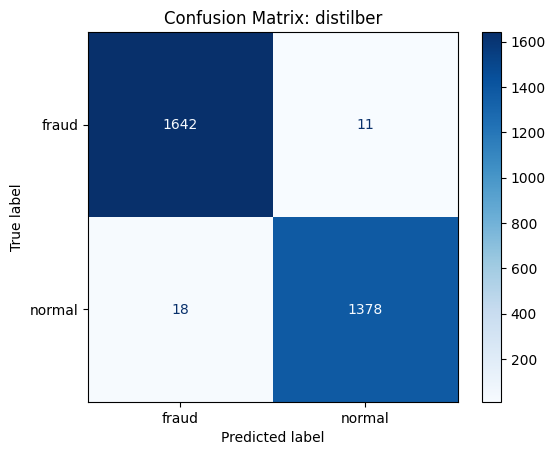

In [29]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('distilber', df_test)

# Plot evaluation comparison

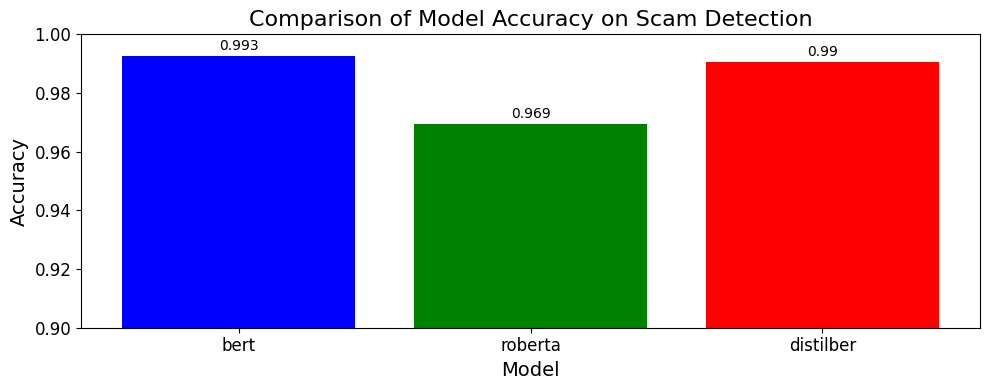

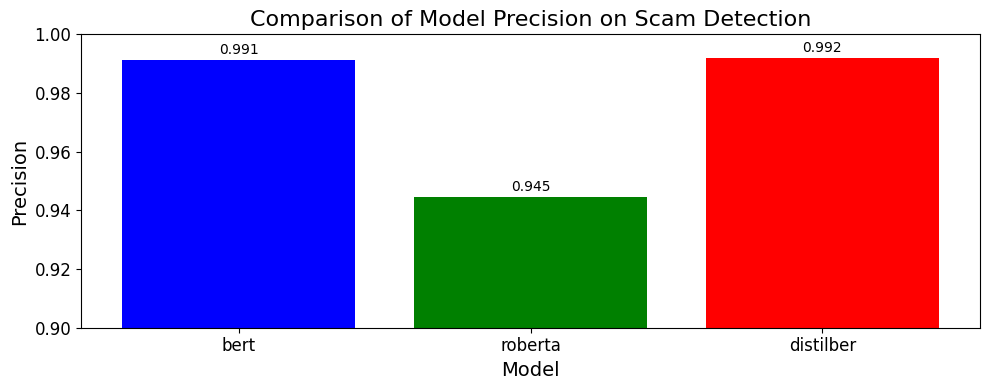

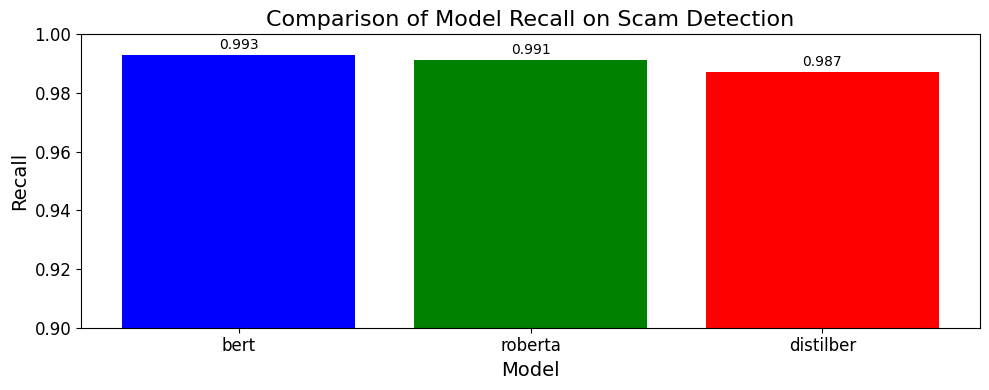

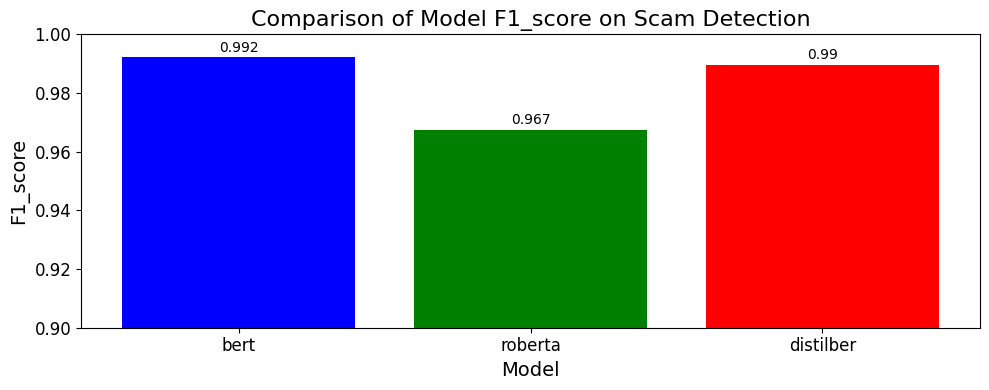

In [30]:
# Plot the evaluation metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plt.figure(figsize=(10, 4))
    bars = plt.bar(evaluation_results.keys(), [evaluation_results[model][metric] for model in evaluation_results], color=['blue', 'green', 'red', 'purple', 'yellow'])
    
  # Add data labels above each bar for clarity
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 3), ha='center', va='bottom')

    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.title(f'Comparison of Model {metric.capitalize()} on Scam Detection', fontsize=16)
    plt.ylim(0.9, 1)  # Set y-axis limit to make differences more distinct
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()